In [1]:
import nibabel as nib
import numpy as np

# Define the file paths
ct_scan_file_path = '/Users/syedreehan/Desktop/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii.gz'
mask_file_path = '/Users/syedreehan/Desktop/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii.gz'

# Load the CT scan and mask using nibabel
ct_scan = nib.load(ct_scan_file_path)
mask = nib.load(mask_file_path)

# Get the data as numpy arrays
ct_scan_img = ct_scan.get_fdata()
mask_img = mask.get_fdata()

# Display basic information about the images
(ct_scan_img.shape, mask_img.shape, ct_scan_img.dtype, mask_img.dtype)


((512, 512, 121), (512, 512, 121), dtype('float64'), dtype('float64'))

In [2]:
def normalize_scan(scan):
    # Set the bounds for the HU values
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    
    # Clip the HU values to the specified range
    scan_clipped = np.clip(scan, MIN_BOUND, MAX_BOUND)
    
    # Normalize the values to 0-1
    scan_normalized = (scan_clipped - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    
    # Set any remaining values outside the 0-1 range to 0 (this should not happen after clipping)
    scan_normalized[scan_normalized > 1] = 1.
    scan_normalized[scan_normalized < 0] = 0.
    
    return scan_normalized

# Assuming 'ct_scan_img' is your loaded scan
ct_scan_normalized = normalize_scan(ct_scan_img)


In [3]:
from scipy.ndimage import zoom

def resize_scan(scan, new_shape):
    # Compute the resize factor for each dimension
    resize_factor = np.array(new_shape) / np.array(scan.shape)
    
    # Resizing using zoom with linear interpolation
    scan_resized = zoom(scan, resize_factor, mode='nearest')
    
    return scan_resized

# Define the new desired shape, for example (128, 128, 128)
new_shape = (128, 128, 128)

# Assuming 'ct_scan_normalized' is your normalized scan
ct_scan_resized = resize_scan(ct_scan_normalized, new_shape)


In [4]:
def prepare_mask(mask):
    # Remove trachea: set label 5 to 0
    mask[mask == 5] = 0
    
    # Combine left and right lungs: set labels 3 and 4 to 1
    mask[(mask == 3) | (mask == 4)] = 1
    
    return mask

# Assuming 'mask_img' is your loaded mask
mask_prepared = prepare_mask(mask_img)


In [5]:
import numpy as np
import nibabel as nib

# Load and normalize the CT scan
def normalize_scan(scan):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    scan_clipped = np.clip(scan, MIN_BOUND, MAX_BOUND)
    scan_normalized = (scan_clipped - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    scan_normalized[scan_normalized > 1] = 1.
    scan_normalized[scan_normalized < 0] = 0.
    return scan_normalized

# Prepare the mask
def prepare_mask(mask):
    mask[mask == 5] = 0  # Remove trachea
    mask[(mask == 3) | (mask == 4)] = 1  # Combine left and right lungs
    return mask

# Define the file paths
ct_scan_file_path = '/Users/syedreehan/Desktop/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii.gz'
mask_file_path = '/Users/syedreehan/Desktop/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii.gz'

# Load the CT scan and mask using nibabel
ct_scan = nib.load(ct_scan_file_path)
mask = nib.load(mask_file_path)

# Get the data as numpy arrays
ct_scan_img = ct_scan.get_fdata()
mask_img = mask.get_fdata()

# Normalize the CT scan and prepare the mask
ct_scan_normalized = normalize_scan(ct_scan_img)
mask_prepared = prepare_mask(mask_img)




In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet(input_size=(512, 512, 1)):
    inputs = Input(input_size)

    # Downsampling (Encoding path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # Upsampling (Decoding path)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [7]:
# Assuming 'ct_scan_normalized' is your normalized 3D CT scan with shape (512, 512, depth)
# Assuming 'mask_prepared' is your corresponding 3D mask with the same shape

# Select a single 2D slice to work with (for example, the middle slice of the CT scan)
slice_index = ct_scan_normalized.shape[2] // 2  # Choosing the middle slice for demonstration
X_train = ct_scan_normalized[:, :, slice_index]
Y_train = mask_prepared[:, :, slice_index]

# Expand dimensions to add batch and channel dimensions
X_train = np.expand_dims(X_train, axis=0)  # Adding a batch dimension
X_train = np.expand_dims(X_train, axis=-1) # Adding a channel dimension
Y_train = np.expand_dims(Y_train, axis=0)  # Adding a batch dimension
Y_train = np.expand_dims(Y_train, axis=-1) # Adding a channel dimension

model = unet(input_size=(512, 512, 1))  # Adjust input_size based on your actual data

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=1,  # Single image
    epochs=25,     # Number of epochs, adjust as needed
    verbose=1
)


Epoch 1/25
1/1 [==============================] - 13s 13s/step - loss: 0.6160 - accuracy: 0.7668
Epoch 2/25
1/1 [==============================] - 12s 12s/step - loss: 29.7157 - accuracy: 0.7657
Epoch 3/25
1/1 [==============================] - 11s 11s/step - loss: 3.6907 - accuracy: 0.2328
Epoch 4/25
1/1 [==============================] - 12s 12s/step - loss: 0.8126 - accuracy: 0.2367
Epoch 5/25
1/1 [==============================] - 11s 11s/step - loss: 0.6213 - accuracy: 0.7543
Epoch 6/25
1/1 [==============================] - 11s 11s/step - loss: 0.5753 - accuracy: 0.7677
Epoch 7/25
1/1 [==============================] - 11s 11s/step - loss: 0.8634 - accuracy: 0.7677
Epoch 8/25
1/1 [==============================] - 11s 11s/step - loss: 0.5650 - accuracy: 0.7677
Epoch 9/25
1/1 [==============================] - 11s 11s/step - loss: 0.5608 - accuracy: 0.7677
Epoch 10/25
1/1 [==============================] - 11s 11s/step - loss: 0.5486 - accuracy: 0.7844
Epoch 11/25
1/1 [===========

In [12]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Ensure the tensors are of type float32
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)

    # Calculate intersection and union for Dice coefficient
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (4.5 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Predict and calculate Dice coefficient
pred_mask = model.predict(X_train)
dice_score = dice_coefficient(Y_train, pred_mask)
print("Dice Coefficient:", dice_score.numpy())


1/1 [==============================] - 3s 3s/step
Dice Coefficient: 0.9104835


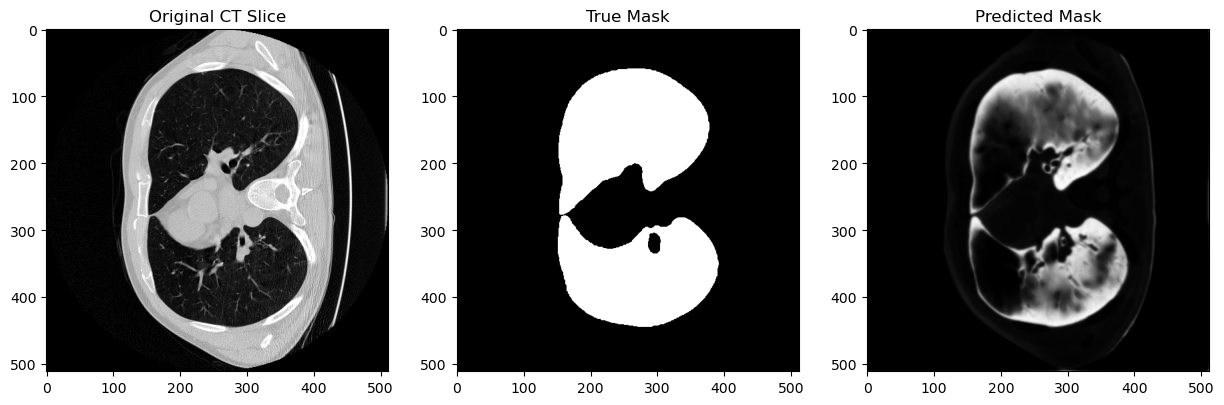

In [13]:
import matplotlib.pyplot as plt

# Assuming you're working with the middle slice of the CT scan and mask
slice_num = ct_scan_normalized.shape[2] // 2

# Plot Original Image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(ct_scan_normalized[:, :, slice_num], cmap='gray')
plt.title('Original CT Slice')

# Plot True Mask
plt.subplot(1, 3, 2)
plt.imshow(mask_prepared[:, :, slice_num], cmap='gray')
plt.title('True Mask')

# Plot Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask[0, :, :, 0], cmap='gray')  # Adjust indexing based on how prediction is shaped
plt.title('Predicted Mask')

plt.show()
